
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\SERAJ\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\SERAJ\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c:\Users\SERAJ\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\SERAJ\AppData\Local\Programs\Python\Python310\lib\site-packages\trait


✅ Generated 400 pairs (200 same, 200 different)


  0%|          | 0/400 [00:00<?, ?it/s]

25-10-28 15:37:36 - vgg_face_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/vgg_face_weights.h5
To: C:\Users\SERAJ\.deepface\weights\vgg_face_weights.h5
100%|██████████| 580M/580M [00:51<00:00, 11.3MB/s]
100%|██████████| 400/400 [06:42<00:00,  1.01s/it]


[vggface] AUC=0.9835 | EER=0.0500 @ thr=0.2639
✅ Generated 400 pairs (200 same, 200 different)


  0%|          | 0/400 [00:00<?, ?it/s]


RuntimeError: Numpy is not available

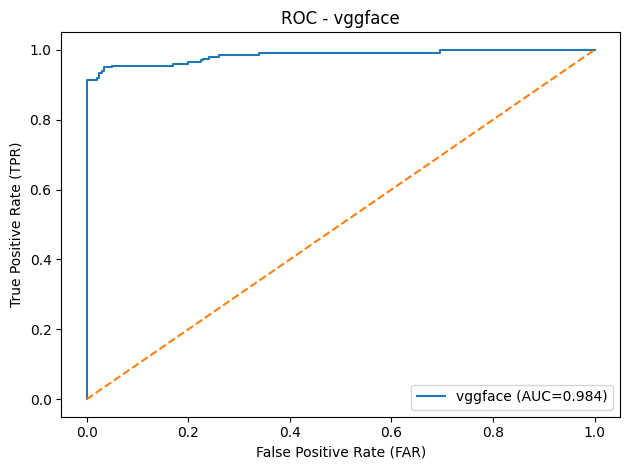

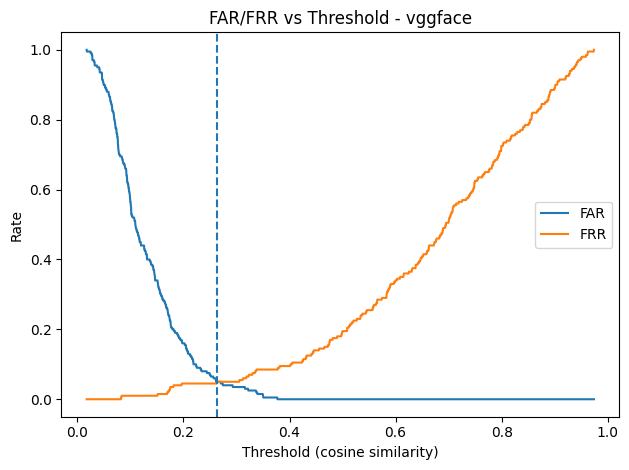

In [2]:
# evaluate_lfw.py
import numpy as np
from tqdm import tqdm
from lfw_pairs import load_lfw_pairs
from models_facenet import FaceNetEmbedder
from models_arcface import ArcFaceEmbedder
from eval_metrics import cosine_similarity, sweep
import cv2
import matplotlib.pyplot as plt
from att_pairs import load_att_pairs as load_lfw_pairs
from models_vggface import VGGFaceEmbedder


def prep(img):
    # sklearn returns RGB float [0..255]? Often uint8; ensure uint8 BGR for ArcFace, RGB for FaceNet handled inside
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)
    return img

def extract_pairs_embeddings(embedder, X1, X2):
    e1, e2 = [], []
    for a,b in tqdm(zip(X1, X2), total=len(X1)):
        img1 = prep(a)
        img2 = prep(b)
        # For ArcFace embedder expects BGR; for FaceNet we passed BGR and convert internally.
        e1.append(embedder.embed(cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)))
        e2.append(embedder.embed(cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)))
    return np.vstack(e1), np.vstack(e2)

def run_eval(model_name="facenet"):
    dataset_path = r"C:\Users\SERAJ\.cache\kagglehub\datasets\kasikrit\att-database-of-faces\versions\2"
    X1, X2, y = load_lfw_pairs(dataset_path)
    # X1, X2, y = load_lfw_pairs("test")
    if model_name == "facenet":
        embedder = FaceNetEmbedder()
    elif model_name == "vggface":
        embedder = VGGFaceEmbedder()
    elif model_name == "arcface":
        embedder = ArcFaceEmbedder()
    else:
        raise ValueError("model_name must be 'facenet' or 'arcface'.")

    E1, E2 = extract_pairs_embeddings(embedder, X1, X2)
    scores = cosine_similarity(E1, E2)
    res = sweep(scores, y, n=2000)
    print(f"[{model_name}] AUC={res['auc']:.4f} | EER={res['eer']:.4f} @ thr={res['eer_thr']:.4f}")

    # Plot ROC
    plt.figure()
    plt.plot(res["fpr"], res["tpr"], label=f"{model_name} (AUC={res['auc']:.3f})")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate (FAR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(f"ROC - {model_name}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"roc_{model_name}.png", dpi=180)

    # Plot FAR/FRR vs threshold (and mark EER)
    plt.figure()
    plt.plot(res["thrs"], res["fars"], label="FAR")
    plt.plot(res["thrs"], res["frrs"], label="FRR")
    plt.axvline(res["eer_thr"], linestyle="--")
    plt.title(f"FAR/FRR vs Threshold - {model_name}")
    plt.xlabel("Threshold (cosine similarity)")
    plt.ylabel("Rate")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"far_frr_{model_name}.png", dpi=180)

    return res

if __name__ == "__main__":
    
    r2 = run_eval("vggface")
    r1 = run_eval("facenet")


In [11]:
!pip install deepface==0.0.91


     ---------------------------------------- 97.3/97.3 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: deepface
    Found existing installation: deepface 0.0.95
    Uninstalling deepface-0.0.95:
      Successfully uninstalled deepface-0.0.95



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kasikrit/att-database-of-faces")

print("Path to dataset files:", path)

100%|██████████| 3.61M/3.61M [00:00<00:00, 3.96MB/s]

Extracting files...


Path to dataset files: C:\Users\SERAJ\.cache\kagglehub\datasets\kasikrit\att-database-of-faces\versions\2


In [5]:
# fichier: att_pairs.py
import os
import cv2
import numpy as np
import random

def load_att_faces(root):
    """Loads AT&T (ORL) face dataset from the given root path."""
    images, labels = [], []
    for person_dir in sorted(os.listdir(root)):
        person_path = os.path.join(root, person_dir)
        if not os.path.isdir(person_path):
            continue
        label = int(person_dir[1:])  # 's1' -> 1
        for file in os.listdir(person_path):
            if file.endswith(".pgm"):
                img = cv2.imread(os.path.join(person_path, file), cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (160, 160))  # match FaceNet input size
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # make 3 channels
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)


def make_att_pairs(images, labels, n_same=200, n_diff=200, seed=42):
    """Generate same-person and different-person pairs."""
    random.seed(seed)
    np.random.seed(seed)
    pairs_X1, pairs_X2, pairs_y = [], [], []

    # Group images by label
    people = {}
    for img, label in zip(images, labels):
        people.setdefault(label, []).append(img)

    # Positive pairs
    for label, imgs in people.items():
        if len(imgs) < 2:
            continue
        combos = [(imgs[i], imgs[j]) for i in range(len(imgs)) for j in range(i+1, len(imgs))]
        random.shuffle(combos)
        for a, b in combos[:min(n_same // len(people), len(combos))]:
            pairs_X1.append(a)
            pairs_X2.append(b)
            pairs_y.append(1)

    # Negative pairs
    all_labels = list(people.keys())
    for _ in range(n_diff):
        l1, l2 = random.sample(all_labels, 2)
        a = random.choice(people[l1])
        b = random.choice(people[l2])
        pairs_X1.append(a)
        pairs_X2.append(b)
        pairs_y.append(0)

    return np.array(pairs_X1), np.array(pairs_X2), np.array(pairs_y)


def load_att_pairs(root, n_same=200, n_diff=200):
    """High-level function returning pairs like fetch_lfw_pairs()."""
    images, labels = load_att_faces(root)
    X1, X2, y = make_att_pairs(images, labels, n_same, n_diff)
    print(f"✅ Generated {len(y)} pairs ({y.sum()} same, {len(y)-y.sum()} different)")
    return X1, X2, y


if __name__ == "__main__":
    path = r"C:\Users\SERAJ\.cache\kagglehub\datasets\kasikrit\att-database-of-faces\versions\2"
    X1, X2, y = load_att_pairs(path)
    print("Shapes:")
    print("X1:", X1.shape)
    print("X2:", X2.shape)
    print("y:", y.shape)


✅ Generated 400 pairs (200 same, 200 different)
Shapes:
X1: (400, 160, 160, 3)
X2: (400, 160, 160, 3)
y: (400,)
